# Model Monitoring on Stroke Prediction Data

## 1.1 Importing Libraries:

In [76]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
from plotly.subplots import make_subplots
import plotly.express as px
from IPython.core.display import display, HTML, Javascript
from plotly.offline import download_plotlyjs,init_notebook_mode
init_notebook_mode(connected=True)

In [77]:
import alibi_detect
from alibi_detect.cd import ChiSquareDrift

## 1.2 Importing the Dataset:


In [78]:
# Load data into a pandas Dataframe
rawdata = pd.read_csv("C:/Users/rahul/Summer Project/Dataset/healthcare-dataset-stroke-data.csv")
# View first 5 rows in the Dataset
rawdata.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [79]:
# View last 5 rows in the Dataset
rawdata.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [80]:
rawdata.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 1.3 Dataset Description 

 There are 12 columns in the dataset namely :
        
 1) **id**: unique identifier
    
 2) **gender**: with 3 categories - "Male", "Female" and "Other"
    
 3) **age**: age of the individual
    
 4) **hypertension**: with 2 categories -'0' and '1'; 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
    
 5) **heart_disease**: with 2 categories0 -'0' and '1'; 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
    
 6) **ever_married**: with 2 categories -"No" and "Yes"
    
 7) **work_type**: with 5 categories -"children", "Govt_jov", "Never_worked", "Private" and "Self-employed"
    
 8) **Residence_type**: with 2 categories - "Rural" and "Urban"
    
 9) **avg_glucose_level**: average glucose level in blood
    
 10) **bmi**: Body Mass Index of the individual
    
 11) **smoking_status**: with 4 categories - "formerly smoked", "never smoked", "smokes" or "Unknown"*
    
 12) **stroke**: with 2 categories -'0' and '1'; 1 if the patient had a stroke or 0 if not
    
 > **Note**: "Unknown" in smoking_status means that the information is unavailable for this patient

# 2. Data Cleansing Task:

In [81]:
#explore missing values
rawdata.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

  ### Handling missing values

  There are 201 missing values in the variable 'bmi'. A graph will be plotted for visualising the data and to solve the problem.

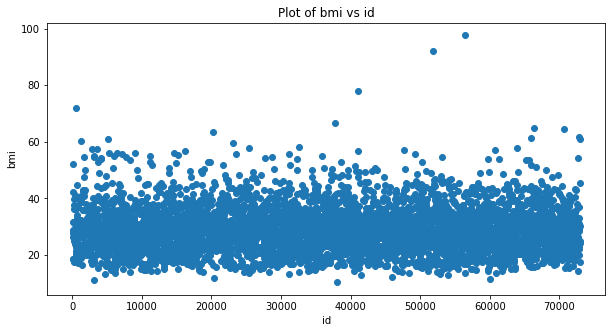

In [82]:
x=rawdata["id"]
y=rawdata["bmi"]
plt.figure(figsize = (10,5))
plt.scatter(x,y)
plt.xlabel('id')
plt.ylabel('bmi')
plt.title('Plot of bmi vs id')
plt.show()

From the above graph, it is evident that there are only a few outliers in the observations of the variable 'bmi' and most of the values of the varible are concentrated around the range 20 to 40. So we perform 'Mean Imputation' here i.e. impute the  missing values by the arithmetic mean of the available observations.

In [83]:
# Replace NA values in 'bmi' column with mean of column (bmi) values
rawdata['bmi'].fillna(rawdata['bmi'].mean(), inplace=True)
# Check whether there is any missing value left in our data
rawdata.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## 3. Exploratory Data Analysis (EDA) :

In [84]:
# Define continuous and categorical data columns.
all_columns = list(rawdata.columns)
categorical_data_cols  = [column for column in all_columns if len(rawdata[column].unique())<=5]
continuous_data_cols  = [column for column in all_columns if column not in categorical_data_cols]
print(f"Continuos Data Columns: {', '.join(continuous_data_cols)}")
print(f"Categorical Data Columns: {', '.join(categorical_data_cols)}")

Continuos Data Columns: id, age, avg_glucose_level, bmi
Categorical Data Columns: gender, hypertension, heart_disease, ever_married, work_type, Residence_type, smoking_status, stroke


## 3.1. Visualization of Continuous Data:


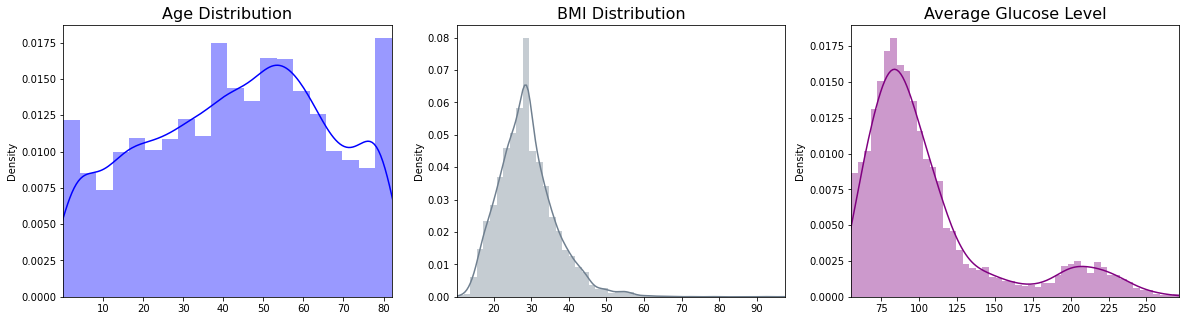

In [85]:

fig = plt.figure(figsize=(20,5))
continuous_data = ["age","bmi","avg_glucose_level"]

plt.subplot(1,3,1)
att = rawdata["age"].values
p = sns.distplot(att,color="blue")
p.set_title("Age Distribution",fontsize=16)
p.set_xlim([min(att),max(att)])

plt.subplot(1,3,2)
att = rawdata["bmi"].values
p = sns.distplot(att,color="slategrey")
p.set_title("BMI Distribution",fontsize=16)
p.set_xlim([min(att),max(att)])

plt.subplot(1,3,3)
att =rawdata["avg_glucose_level"].values
p = sns.distplot(att,color="purple")
p.set_title("Average Glucose Level",fontsize=16)
p.set_xlim([min(att),max(att)])
plt.show()

From the above plots we can see that the Age distribution is close to symmetric and the other two distributions are positively skewed.

In [86]:
import plotly.figure_factory as ff
group_labels = ['0', '1']
l = [rawdata['age'][(rawdata["stroke"] == 0)],rawdata['age'][(rawdata["stroke"] == 1)]]
fig = ff.create_distplot(l, group_labels,curve_type='kde',colors = ['#393E46', 'cyan'])
fig.update_layout(title_text='Age & Stroke Distribution',xaxis_title="Age Distribution",yaxis_title="Frequency")
fig.show()

### Observations:
* We can infer that after the age of 40 the risk of Stroke increases.
* At the age above 76 there is high chance of stroke.

In [87]:
import plotly.figure_factory as ff
group_labels = ['0', '1']
l = [rawdata['bmi'][(rawdata["stroke"] == 0)],rawdata['bmi'][(rawdata["stroke"] == 1)]]
fig = ff.create_distplot(l, group_labels,curve_type='kde',colors = ['orange', 'royalblue'])
fig.update_layout(title_text='BMI & Stroke Distribution',xaxis_title="BMI Distribution",yaxis_title="Frequency")
fig.show()

### Observations:
The World Health Organisation classifies an individual according to BMI as follows :
* Below 18.5 - Underweight
* 18.5-24.9 - Normal
* 25.0-29.9 - Overweight
* 30.0 And Above - Obese

From the above plot we can observe that individuals with BMI 25 and above are more likely to have a stroke, hence the chance of stroke is more in overweight and obese people.

In [88]:
import plotly.figure_factory as ff
group_labels = ['0', '1']
l = [rawdata['avg_glucose_level'][(rawdata["stroke"] == 0)],rawdata['avg_glucose_level'][(rawdata["stroke"] == 1)]]
fig = ff.create_distplot(l, group_labels,curve_type='kde',colors = ['navy', 'plum'])
fig.update_layout(title_text='Avg Glucose Level & Stroke Distribution',xaxis_title="Avg_Glucose_Level Distribution",yaxis_title="Frequency")
fig.show()

### Observations:
* Elevated glucose level results in higher chances of a stroke, a trait observed in diabetic patients.
* From the graph we can infer that above the level of 150/160, the risk of stroke increases.

## 3.2. Visualization of Categorical Data:

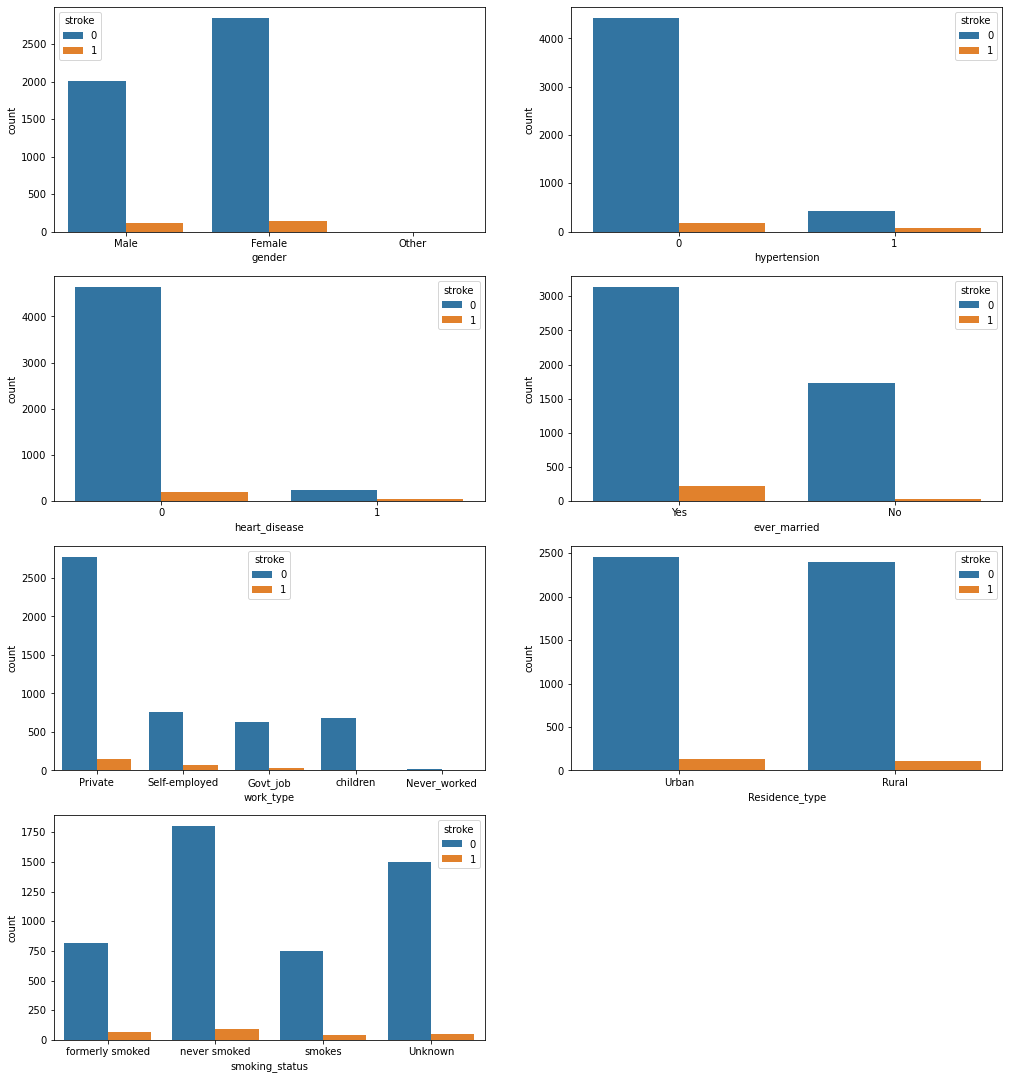

In [89]:
plt.figure(figsize = (17,19))
i = 1
for column in categorical_data_cols[:-1]:
    plt.subplot(4, 2, i)
    sns.countplot(x =rawdata[column], hue = rawdata["stroke"])
    i+=1
plt.show()

### Observations:

* The number of male and female having stroke are almost equal in number.
* The people suffering and not suffering with hypertension have almost same and no sign of stroke. This may be due to the fact that the number of records with stroke "1" is very less.
* The proportion of people who had a stroke in the heart_disease category is much higher than the proportion of people who had a stroke in the No heart_disease category.
* The married people are showing more signs for stroke.
* The people who are having private jobs are more prone to stroke.
* The likelihood of having a stroke is the same for living in an urban region and in a rural region.
* smoking_status does not have much influence on the probability of having a stroke.

## 3.3. Correlation Plot:

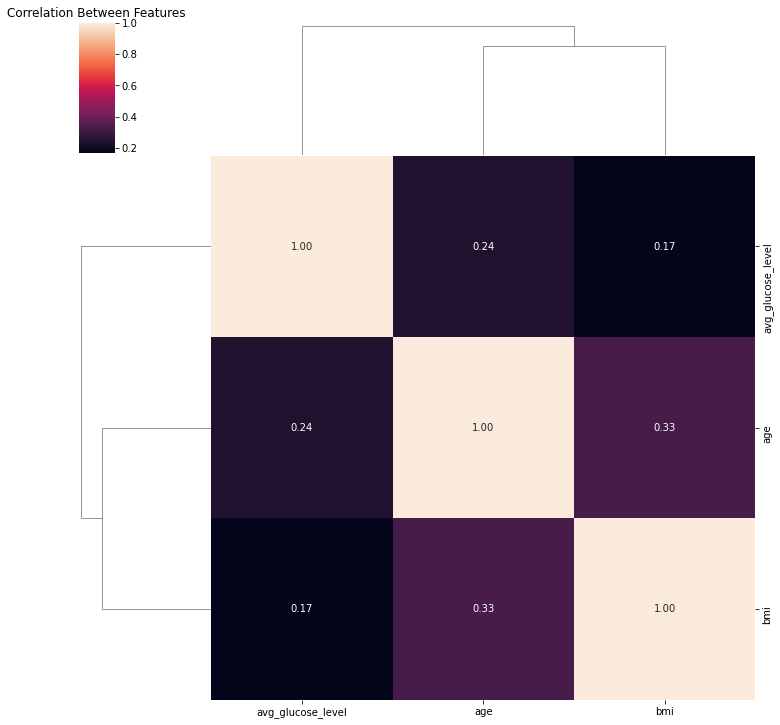

In [90]:
rdata=rawdata.drop(['id']+['hypertension']+['stroke']+['heart_disease'],axis=1)
corr_data = rdata.corr() # It checks the correlation between the numerical values in the data.
sns.clustermap(corr_data,annot= True,fmt = '.2f')
# While annot shows the numerical values on the chart, fmt determines how many digits will be displayed after the comma.

plt.title('Correlation Between Features')
plt.show();


From the above correlation plot, it is quite evident that there is almost no correlation among the continuous features.

 ## 4. Data preprocessing :

In [91]:
# Shuffle the rows of the dataset for future purposes
data = rawdata.sample(frac=1,random_state=4).reset_index(drop=True)

In [92]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,58007,Female,36.0,0,0,Yes,Private,Urban,87.88,34.7,smokes,0
1,4528,Male,45.0,1,0,No,Private,Rural,85.52,36.4,never smoked,0
2,61715,Male,55.0,0,0,Yes,Private,Rural,56.42,31.8,never smoked,0
3,875,Female,34.0,0,0,No,Private,Urban,67.66,22.4,never smoked,0
4,54869,Female,30.0,0,0,Yes,Private,Urban,116.98,26.0,never smoked,0


In [93]:
data.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,37038,Male,15.0,0,0,No,children,Urban,95.86,18.100000,Unknown,0
5106,49086,Female,23.0,0,0,No,Private,Urban,60.50,27.100000,formerly smoked,0
5107,44325,Male,78.0,0,0,Yes,Self-employed,Rural,126.39,21.300000,smokes,0
5108,40899,Female,78.0,0,0,Yes,Self-employed,Rural,60.67,28.893237,formerly smoked,1
5109,50371,Male,56.0,0,0,Yes,Private,Urban,63.18,31.500000,Unknown,0


### Encoding Categorical Features with One-Hot Encoder :

In [94]:
# Categorical Columns: 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
from sklearn.preprocessing import OneHotEncoder

# Initialize One Hot Encoder
one_hot_encoder = OneHotEncoder()
# Fit and Transform the columns
data_temp = one_hot_encoder.fit_transform(data[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]).toarray()

# Get newly encoded columns and concat them to the Dataframe
encodings = pd.DataFrame(columns = one_hot_encoder.get_feature_names_out(),data = data_temp)
encodings = encodings.astype(int)
data = pd.concat([data,encodings] , axis=1)
Stroke=data['stroke']

# Drop original columns from the dataset after encoding is done
data.drop(['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','stroke'],axis = 1, inplace=True)
data=pd.concat([data,Stroke],axis=1)
data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,58007,36.0,0,0,87.88,34.7,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,4528,45.0,1,0,85.52,36.4,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
2,61715,55.0,0,0,56.42,31.8,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3,875,34.0,0,0,67.66,22.4,1,0,0,1,...,1,0,0,0,1,0,0,1,0,0
4,54869,30.0,0,0,116.98,26.0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0


In [95]:
data.tail()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
5105,37038,15.0,0,0,95.86,18.100000,0,1,0,1,...,0,0,1,0,1,1,0,0,0,0
5106,49086,23.0,0,0,60.50,27.100000,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0
5107,44325,78.0,0,0,126.39,21.300000,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
5108,40899,78.0,0,0,60.67,28.893237,1,0,0,0,...,0,1,0,1,0,0,1,0,0,1
5109,50371,56.0,0,0,63.18,31.500000,0,1,0,0,...,1,0,0,0,1,1,0,0,0,0


In [96]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,...,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.585910,0.413894,0.000196,0.343836,...,0.572407,0.160274,0.134442,0.491977,0.508023,0.302153,0.173190,0.370254,0.154403,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.492612,0.492578,0.013989,0.475034,...,0.494778,0.366896,0.341160,0.499985,0.499985,0.459236,0.378448,0.482920,0.361370,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
#Exporting the one hot encoded dataset as a csv file in local drive
exceldata=data.to_csv("C:\\Users\\rahul\\Summer Project\\Dataset\\healthcare-dataset-stroke-data-after-one-hot-encoding.csv",index=False)

## 5. Splitting the dataset :

Now we will split the data into six parts viz. train data (approx 60%), test data (approx 10%), live dataset1 (10%), live dataset2 (10%), live dataset3 (10%).

In [98]:
train_data=data.iloc[:3070]
test_data=data.iloc[3070:3577]
l1=data.iloc[3577:4088]
l2=data.iloc[4088:4599]
l3=data.iloc[4599:]

## 5.1. Showing the first and last rows of each of the splitted datasets:

In [99]:
train_data.head(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,58007,36.0,0,0,87.88,34.7,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [100]:
train_data.tail(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
3069,55459,60.0,0,0,91.82,28.3,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0


In [101]:
test_data.head(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
3070,6048,65.0,0,0,104.12,27.4,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0


In [102]:
test_data.tail(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
3576,50001,34.0,0,0,86.36,32.1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [103]:
l1.head(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
3577,10445,54.0,0,0,81.78,27.3,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


In [104]:
l1.tail(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
4087,24257,4.0,0,0,90.42,16.2,0,1,0,1,...,0,0,1,1,0,1,0,0,0,0


In [105]:
l2.head(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
4088,65946,53.0,0,0,123.87,28.8,0,1,0,0,...,1,0,0,1,0,1,0,0,0,0


In [106]:
l2.tail(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
4598,37413,39.0,0,0,77.54,32.7,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0


In [107]:
l3.head(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
4599,35332,63.0,0,0,93.24,28.8,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [108]:
l3.tail(1)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
5109,50371,56.0,0,0,63.18,31.5,0,1,0,0,...,1,0,0,0,1,1,0,0,0,0


## 6. Checking presence of data imbalance in train data:

In [109]:
#Showing the count of the no. of persons who had a stroke
train_data['stroke'].value_counts()

0    2913
1     157
Name: stroke, dtype: int64

We make a frequency plot of the target variable 'stroke' to show the data imbalance in the dataset visually.

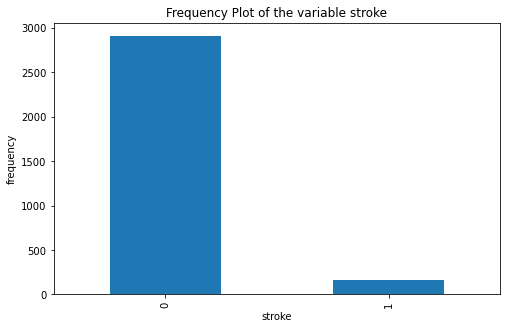

In [110]:
#Visualising the frequency plot
plt.figure(figsize = (8,5))
train_data['stroke'].value_counts().plot(kind='bar')
plt.xlabel('stroke')
plt.ylabel('frequency')
plt.title('Frequency Plot of the variable stroke')
plt.show()

Clearly, there is a data imbalance in our train data. So we will use SMOTE for solving this problem.

## 7. Training the model using different classifiers and K-fold cross-validation:

Here we will train our model using *Logistic Regression*, *Support Vector Classifier*, *Random Forest* and *K-Nearest Neighbour* (KNN) Algorithm.
We will validate our model by **K-fold cross Validation** choosing **K=10** and taking **AUC(Area Under Curve)** score as the measure of performance of the models.
We will perform **SMOTE(Synthetic Minority Oversampling Technique)** on train data sets, each of the times of fitting the models.

In [111]:
#creating 10 parts of our dataset
N=3070
for i in range(1,11):
    globals()['d%s' % i] =  train_data.iloc[(i-1)*(N//10):i*(N//10)]

In [112]:
#creating empty lists to store AUC scores for different models in K-fold cross-validation
lr_auc=[]
svc_auc=[]
rfc_auc=[]
knn_auc=[]

In [113]:
#Model Fitting
L=[d1,d2,d3,d4,d5,d6,d7,d8,d9,d10]
for i in L:
    #creating train and validation datasets for each iteration
    val=i
    train=pd.concat([train_data, val]).drop_duplicates(keep=False)
    #Splitting the train dataset into feature vectors and target vector
    trainY=train['stroke']
    trainX=train.drop(['stroke']+['id'],axis=1)
    #performing SMOTE
    smote=SMOTE(k_neighbors=1)
    trainX_smote,trainY_smote=smote.fit_resample(trainX,trainY)
    # 7.1 Fitting logistic Regression Model
    from sklearn.linear_model import LogisticRegression
    lr=LogisticRegression()
    lr.fit(trainX_smote,trainY_smote)
    # 7.2 Fitting SVC 
    from sklearn.svm import SVC
    svc=SVC(random_state = 87,probability=True)
    svc.fit(trainX_smote,trainY_smote)
    # 7.3 Fitting Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(random_state=87)
    rfc.fit(trainX_smote,trainY_smote)
    # 7.4 Fitting KNN Classifier
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 10)
    knn.fit(trainX_smote,trainY_smote)
    #Splitting the validation dataset into feature vectors and target vector
    valY=val['stroke']
    valX=val.drop(['stroke']+['id'],axis=1)
    # 8.1 Classification using Logistic Regression
    lr_pred_val = lr.predict(valX)
    # 8.2 Classification using SVC
    svc_pred_val = svc.predict(valX)
    # 8.3 Classification using Random Forest Classifier
    rfc_pred_val = rfc.predict(valX)
    # 8.4 Classification using KNN Classifier
    knn_pred_val = knn.predict(valX)
    #Storing AUC scores
    lr_auc.append(roc_auc_score(valY,lr_pred_val))
    svc_auc.append(roc_auc_score(valY,svc_pred_val))
    rfc_auc.append(roc_auc_score(valY,rfc_pred_val))
    knn_auc.append(roc_auc_score(valY,knn_pred_val))

In [114]:
#Showing the average AUC scores of the different models
import statistics
print(f"The average AUC score of the Logistic model is        {statistics.mean(lr_auc)}")
print(f"The average AUC score of the SVC  model is            {statistics.mean(svc_auc)}")
print(f"The average AUC score of the Random Forest model is   {statistics.mean(rfc_auc)}")
print(f"The average AUC score of the KNN model is             {statistics.mean(knn_auc)}")

The average AUC score of the Logistic model is        0.5367535441300085
The average AUC score of the SVC  model is            0.7386153110611822
The average AUC score of the Random Forest model is   0.5084098002288808
The average AUC score of the KNN model is             0.6810130436058963


>Note that the average AUC score of SVC is highest among the six models. So, we will finally fit SVC over the entire train data set.

In [115]:
#Splitting the train dataset into feature vectors and target vector    
train_Y=train_data['stroke']
train_X=train_data.drop(['stroke']+['id'],axis=1)
##performing SMOTE
smote=SMOTE(k_neighbors=1)
train_X_smote,train_Y_smote=smote.fit_resample(train_X,train_Y)
#Fitting SVC
svc.fit(train_X_smote,train_Y_smote)

SVC(probability=True, random_state=87)

## 8. Checking the Performance measures for the selected model on the test dataset:

In [116]:
# Splitting the test dataset into feature vectors and output vector
testY=test_data['stroke']
testX=test_data.drop(['stroke']+['id'],axis=1)

In [117]:
# Classification using SVC
svc_pred_test = svc.predict(testX)

In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score, precision_score
cm = confusion_matrix(testY,svc_pred_test)
cm

array([[358, 127],
       [  6,  16]], dtype=int64)

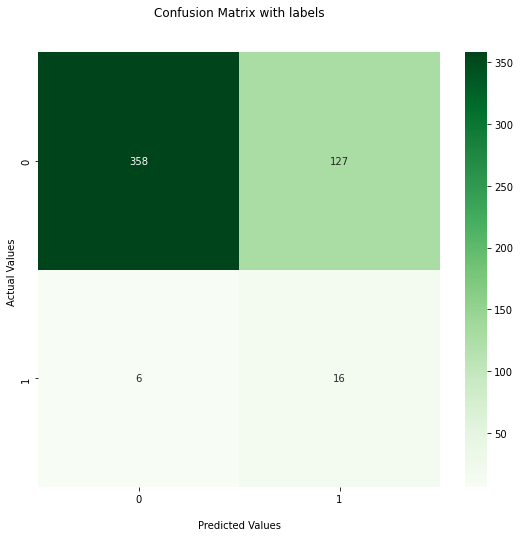

In [119]:
plt.figure(figsize=(9, 8))
cmplot=sns.heatmap(cm, annot = True, fmt = "d",cmap='Greens')
cmplot.set_title('Confusion Matrix with labels\n\n');
cmplot.set_xlabel('\nPredicted Values')
cmplot.set_ylabel('Actual Values ')
plt.show()

In [120]:
acc= accuracy_score(testY,svc_pred_test)
acc

0.73767258382643

In [121]:
rec=recall_score(testY,svc_pred_test)
rec

0.7272727272727273

In [122]:
precision=precision_score(testY,svc_pred_test)
precision

0.11188811188811189

In [123]:
sensitivity=cm[1,1]/(cm[1,1]+cm[1,0])
sensitivity

0.7272727272727273

In [124]:
specificity=cm[0,0]/(cm[0,0]+cm[0,1])
specificity

0.7381443298969073

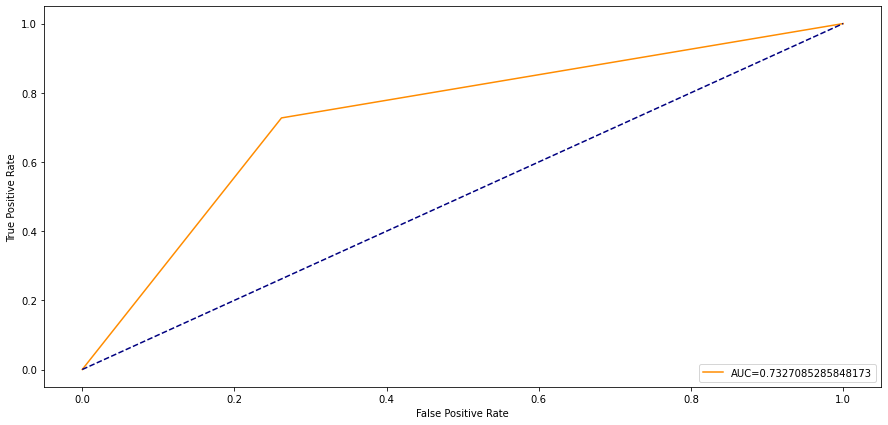

In [125]:
# ROC-AUC for SVC on test data
from sklearn.metrics import roc_curve
fpr, tpr,_ = roc_curve(testY,svc_pred_test)
auc = roc_auc_score(testY,svc_pred_test)
plt.figure(figsize = (15,7))
plt.plot(fpr,tpr,label="AUC="+str(auc),color='darkorange')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The above permorfance measures on the test data indicate that the model fits the data well enough.

# 9. Prediction Drift

In [126]:
#Splitting the live datasets into feature vectors and output vector
l1Y=l1['stroke']
l1X=l1.drop(['stroke']+['id'],axis=1)
l2Y=l2['stroke']
l2X=l2.drop(['stroke']+['id'],axis=1)
l3Y=l3['stroke']
l3X=l3.drop(['stroke']+['id'],axis=1)

In [127]:
# Predicted probabilities for the live datasets
svc_prob_l1 = svc.predict_proba(l1X)
svc_prob_l2 = svc.predict_proba(l2X)
svc_prob_l3 = svc.predict_proba(l3X)
# Predicted probabilities for the test dataset
svc_prob_test=svc.predict_proba(testX)

In [128]:
# K-S test for live dataset 1
from scipy.stats import ks_2samp
test_l1_1 = ks_2samp(svc_prob_test[0:507,1],svc_prob_l1[0:511,1])
print(test_l1_1)

KstestResult(statistic=0.03771851611683013, pvalue=0.8426451588117593)


In [129]:
# K-S test for live dataset 2
test_l2 = ks_2samp(svc_prob_test[0:507,1],svc_prob_l2[0:511,1])
print(test_l2)

KstestResult(statistic=0.06321672707341833, pvalue=0.2456438132009825)


In [130]:
# K-S test for live dataset 3
test_l3 = ks_2samp(svc_prob_test[0:507,1],svc_prob_l3[0:511,1])
print(test_l3)

KstestResult(statistic=0.07090556089502349, pvalue=0.1444540155048032)


In [131]:
# K-S test for live dataset 4
l4 = pd.read_csv("C:/Users/rahul/Summer Project/Dataset/Live Dataet 4.csv")
l4Y=l4['stroke']
l4X=l4.drop(['stroke']+['id'],axis=1)
svc_prob_l4 = svc.predict_proba(l4X)
test_l4 = ks_2samp(svc_prob_test[0:507,1],svc_prob_l4[0:299,1])
print(test_l4)

KstestResult(statistic=0.42792213360775233, pvalue=8.992398632834792e-32)


 Here we take 5% level of significance.
### Observations :
 * From the above tests,it is pretty clear  that prediction drift has occurred only for the fourth live dataset. 
 * In the other three live datasets, no prediction drift occurred.

# 10. Feature Drift

Now we will perform **Kolmogorov-Smirnov test for the continuous variables** and **for categorical variables**, we will use **Chi Square Test**. We will **compare the p values** obtained from the tests mentioned above **with** the corresponding **Benjamini Hochberg FDR values to detect whether there is a drift or not** for a particular feature. The results are shown in a table for each of the live datasets.

In [132]:
#Storing the coloumn heads for categorical and continuous variables
L1=['age','avg_glucose_level','bmi']
L2=list(train_X_smote.columns)
for i in L1:
    L2.remove(i)

## 10.1 For live dataset 1

In [133]:
# Test(Kolmogorov-Smirnov or K-S test) for determinig the presence of feature drift in the continuous variables

dict1=dict() #Creating an empty dictionary for storing features and p values

for i in L1:
    test_statistic,pvalue = ks_2samp(train_X_smote[i],l1X[i])
    print(f"\nFor {i} : K-StestResult(statistic={test_statistic},pvalue={pvalue})")
    dict1[i]=pvalue


For age : K-StestResult(statistic=0.2634388123151296,pvalue=2.82800503051853e-29)

For avg_glucose_level : K-StestResult(statistic=0.10942713781194094,pvalue=2.3492753279064083e-05)

For bmi : K-StestResult(statistic=0.08193649763560744,pvalue=0.0034155056455822397)


In [134]:
# Test(Chi-Squared Test) for determinig the presence of feature drift in the continuous variables
from alibi_detect.cd import ChiSquareDrift
trainX_categoricals=train_X_smote.loc[:, train_X_smote.columns.drop(L1)]
l1_categoricals=l1X.loc[:, l1X.columns.drop(L1)]
for i in L2:
    cd=ChiSquareDrift(trainX_categoricals[i].to_numpy())
    p_value=cd.predict(l1_categoricals[i].to_numpy())
    test_statistic,pvalue =(p_value["data"]["distance"][0],p_value["data"]["p_val"][0])
    print(f"\nFor {i} : ChiSquareTestResult(statistic={test_statistic},pvalue={pvalue})")
    dict1[i]=pvalue


For hypertension : ChiSquareTestResult(statistic=4.144659996032715,pvalue=0.04176604747772217)

For heart_disease : ChiSquareTestResult(statistic=0.004498933907598257,pvalue=0.9465227127075195)

For gender_Female : ChiSquareTestResult(statistic=36.91356658935547,pvalue=1.2348372324666457e-09)

For gender_Male : ChiSquareTestResult(statistic=16.124479293823242,pvalue=5.931243867962621e-05)

For gender_Other : ChiSquareTestResult(statistic=0.0,pvalue=1.0)

For ever_married_No : ChiSquareTestResult(statistic=48.929786682128906,pvalue=2.6529106602474206e-12)

For ever_married_Yes : ChiSquareTestResult(statistic=3.7446796894073486,pvalue=0.05297587811946869)

For work_type_Govt_job : ChiSquareTestResult(statistic=10.473331451416016,pvalue=0.0012111011892557144)

For work_type_Never_worked : ChiSquareTestResult(statistic=0.0,pvalue=1.0)

For work_type_Private : ChiSquareTestResult(statistic=14.444476127624512,pvalue=0.00014435258344747126)

For work_type_Self-employed : ChiSquareTestResult(

In [135]:
# Showing the result of drift detection

dictkey_list1=list(dict1.keys())  # creating a list containing  the dict1 keys
pvalue_list1=list(dict1.values()) # creating a list containing  the dict1 values
pvalue_list1.sort() #sorting the list
rank1_pvalues=list(range(1,22)) # rank list of p values
delta=0.05
BH_FDR_1=[j*(delta/21) for j in rank1_pvalues] # creating a list containing  the Benjamini-Hochberg FDR values 
# Creating list of Feature and Drift/Decision
feature_l1=[]
decision_l1=[]
for i in pvalue_list1:
    for j in dictkey_list1:
        if dict1[j]==i:
            feature_l1.append(j)
for i in range(0,21):   
    if pvalue_list1[i]<=BH_FDR_1[i]:
        decision_l1.append("Drift")
    else:
         decision_l1.append("No Drift")
del feature_l1[21:23] # nahole besi niye nicchilo dictionary te duto value jegulor p value 1

# Creating DataFrame
dictionary1={"Rank":rank1_pvalues,"Feature":feature_l1,"p-values":pvalue_list1,"BH_FDR":BH_FDR_1,"Decision":decision_l1}
df_l1=pd.DataFrame(dictionary1)
df_l1

,Rank,Feature,p-values,BH_FDR,Decision
0,1,age,2.828005e-29,0.002381,Drift
1,2,smoking_status_Unknown,1.588456e-15,0.004762,Drift
2,3,Residence_type_Rural,2.411831e-12,0.007143,Drift
3,4,ever_married_No,2.652911e-12,0.009524,Drift
4,5,gender_Female,1.234837e-09,0.011905,Drift
5,6,work_type_children,5.730432e-07,0.014286,Drift
6,7,smoking_status_never smoked,2.055663e-06,0.016667,Drift
7,8,smoking_status_smokes,1.697703e-05,0.019048,Drift
8,9,avg_glucose_level,2.349275e-05,0.021429,Drift
9,10,gender_Male,5.931244e-05,0.023810,Drift


## 10.2 For live dataset 2

In [136]:
# Test(Kolmogorov-Smirnov or K-S test) for determinig the presence of feature drift in the continuous variables

dict2=dict() #Creating an empty dictionary for storing features and p values

for i in L1:
    test_statistic,pvalue = ks_2samp(train_X_smote[i],l2X[i])
    print(f"\nFor {i} : K-StestResult(statistic={test_statistic},pvalue={pvalue})")
    dict2[i]=pvalue


For age : K-StestResult(statistic=0.294742913036439,pvalue=1.1159878644600099e-36)

For avg_glucose_level : K-StestResult(statistic=0.14993318970295114,pvalue=1.1039671399259987e-09)

For bmi : K-StestResult(statistic=0.10646383745716449,pvalue=4.3060250340509754e-05)


In [137]:
# Test(Chi-Squared Test) for determinig the presence of feature drift in the continuous variables
l2_categoricals=l2X.loc[:, l2X.columns.drop(L1)]
for i in L2:
    cd=ChiSquareDrift(trainX_categoricals[i].to_numpy())
    p_value=cd.predict(l2_categoricals[i].to_numpy())
    test_statistic,pvalue =(p_value["data"]["distance"][0],p_value["data"]["p_val"][0])
    print(f"\nFor {i} : ChiSquareTestResult(statistic={test_statistic},pvalue={pvalue})")
    dict2[i]=pvalue


For hypertension : ChiSquareTestResult(statistic=0.4813259541988373,pvalue=0.4878223240375519)

For heart_disease : ChiSquareTestResult(statistic=0.2682144045829773,pvalue=0.6045320630073547)

For gender_Female : ChiSquareTestResult(statistic=39.00444030761719,pvalue=4.2284259427205484e-10)

For gender_Male : ChiSquareTestResult(statistic=14.014263153076172,pvalue=0.00018142913177143782)

For gender_Other : ChiSquareTestResult(statistic=2.3725955486297607,pvalue=0.12348159402608871)

For ever_married_No : ChiSquareTestResult(statistic=70.9418716430664,pvalue=3.679060474874962e-17)

For ever_married_Yes : ChiSquareTestResult(statistic=10.455445289611816,pvalue=0.0012228841660544276)

For work_type_Govt_job : ChiSquareTestResult(statistic=18.474273681640625,pvalue=1.7221327652805485e-05)

For work_type_Never_worked : ChiSquareTestResult(statistic=0.24629773199558258,pvalue=0.6196941137313843)

For work_type_Private : ChiSquareTestResult(statistic=20.8300838470459,pvalue=5.01883823744719

In [138]:
# Showing the result of drift detection

dictkey_list2=list(dict2.keys())  # creating a list containing  the dict1 keys
pvalue_list2=list(dict2.values()) # creating a list containing  the dict1 values
pvalue_list2.sort() #sorting the list
rank2_pvalues=list(range(1,22)) # rank list of p values
delta=0.05
BH_FDR_2=[j*(delta/21) for j in rank2_pvalues] # creating a list containing  the Benjamini-Hochberg FDR values 
# Creating list of Feature and Drift/Decision
feature_l2=[]
decision_l2=[]
for i in pvalue_list2:
    for j in dictkey_list2:
        if dict2[j]==i:
            feature_l2.append(j)
for i in range(0,21):   
    if pvalue_list2[i]<=BH_FDR_2[i]:
        decision_l2.append("Drift")
    else:
         decision_l2.append("No Drift")

# Creating DataFrame
dictionary2={"Rank":rank2_pvalues,"Feature":feature_l2,"p-values":pvalue_list2,"BH_FDR":BH_FDR_2,"Decision":decision_l2}
df_l2=pd.DataFrame(dictionary2)
df_l2

,Rank,Feature,p-values,BH_FDR,Decision
0,1,age,1.115988e-36,0.002381,Drift
1,2,ever_married_No,3.679060e-17,0.004762,Drift
2,3,smoking_status_Unknown,5.083572e-12,0.007143,Drift
3,4,Residence_type_Rural,2.707583e-11,0.009524,Drift
4,5,smoking_status_never smoked,3.809454e-10,0.011905,Drift
5,6,gender_Female,4.228426e-10,0.014286,Drift
6,7,avg_glucose_level,1.103967e-09,0.016667,Drift
7,8,work_type_Private,5.018838e-06,0.019048,Drift
8,9,work_type_Govt_job,1.722133e-05,0.021429,Drift
9,10,bmi,4.306025e-05,0.023810,Drift


# 10.3 For live dataset 3

In [139]:
# Test(Kolmogorov-Smirnov or K-S test) for determinig the presence of feature drift in the continuous variables

dict3=dict() #Creating an empty dictionary for storing features and p values

for i in L1:
    test_statistic,pvalue = ks_2samp(train_X_smote[i],l3X[i])
    print(f"\nFor {i} : K-StestResult(statistic={test_statistic},pvalue={pvalue})")
    dict3[i]=pvalue


For age : K-StestResult(statistic=0.23680001182364233,pvalue=1.1396072275654955e-23)

For avg_glucose_level : K-StestResult(statistic=0.10479173258683155,pvalue=6.0160916429241595e-05)

For bmi : K-StestResult(statistic=0.1054608432541082,pvalue=5.2643288097398155e-05)


In [140]:
# Test(Chi-Squared Test) for determinig the presence of feature drift in the continuous variables
l3_categoricals=l3X.loc[:, l3X.columns.drop(L1)]
for i in L2:
    cd=ChiSquareDrift(trainX_categoricals[i].to_numpy())
    p_value=cd.predict(l3_categoricals[i].to_numpy())
    test_statistic,pvalue =(p_value["data"]["distance"][0],p_value["data"]["p_val"][0])
    print(f"\nFor {i} : ChiSquareTestResult(statistic={test_statistic},pvalue={pvalue})")
    dict3[i]=pvalue


For hypertension : ChiSquareTestResult(statistic=0.1230868473649025,pvalue=0.725710391998291)

For heart_disease : ChiSquareTestResult(statistic=1.1180850267410278,pvalue=0.2903311848640442)

For gender_Female : ChiSquareTestResult(statistic=15.630699157714844,pvalue=7.699439447605982e-05)

For gender_Male : ChiSquareTestResult(statistic=39.36008834838867,pvalue=3.5242733731344345e-10)

For gender_Other : ChiSquareTestResult(statistic=0.0,pvalue=1.0)

For ever_married_No : ChiSquareTestResult(statistic=61.029327392578125,pvalue=5.623085818588086e-15)

For ever_married_Yes : ChiSquareTestResult(statistic=7.170257568359375,pvalue=0.007412212900817394)

For work_type_Govt_job : ChiSquareTestResult(statistic=11.483617782592773,pvalue=0.0007021232158876956)

For work_type_Never_worked : ChiSquareTestResult(statistic=7.79022216796875,pvalue=0.005252973176538944)

For work_type_Private : ChiSquareTestResult(statistic=10.283634185791016,pvalue=0.0013421535259112716)

For work_type_Self-employ

In [141]:
# Showing the result of drift detection

dictkey_list3=list(dict3.keys())  # creating a list containing  the dict1 keys
pvalue_list3=list(dict3.values()) # creating a list containing  the dict1 values
del pvalue_list3[7] #eleminating the nan element  from the list
pvalue_list3.sort() #sorting the list
rank3_pvalues=list(range(1,21)) # rank list of p values
delta=0.05
BH_FDR_3=[j*(delta/20) for j in rank3_pvalues] # creating a list containing  the Benjamini-Hochberg FDR values 
# Creating list of Feature and Drift/Decision
feature_l3=[]
decision_l3=[]
for i in pvalue_list3:
    for j in dictkey_list3:
        if dict3[j]==i:
            feature_l3.append(j)
for i in range(0,20):   
    if pvalue_list3[i]<=BH_FDR_3[i]:
        decision_l3.append("Drift")
    else:
         decision_l3.append("No Drift")

# Creating DataFrame
dictionary3={"Rank":rank3_pvalues,"Feature":feature_l3,"p-values":pvalue_list3,"BH_FDR":BH_FDR_3,"Decision":decision_l3}
df_l3=pd.DataFrame(dictionary3)
df_l3

,Rank,Feature,p-values,BH_FDR,Decision
0,1,age,1.139607e-23,0.0025,Drift
1,2,smoking_status_Unknown,4.673530e-17,0.0050,Drift
2,3,ever_married_No,5.623086e-15,0.0075,Drift
3,4,gender_Male,3.524273e-10,0.0100,Drift
4,5,work_type_children,3.530344e-09,0.0125,Drift
5,6,Residence_type_Rural,5.131363e-08,0.0150,Drift
6,7,smoking_status_smokes,6.697006e-08,0.0175,Drift
7,8,smoking_status_never smoked,3.271856e-06,0.0200,Drift
8,9,bmi,5.264329e-05,0.0225,Drift
9,10,avg_glucose_level,6.016092e-05,0.0250,Drift


## 10.4 For live dataset 4

In [142]:
# Test(Kolmogorov-Smirnov or K-S test) for determinig the presence of feature drift in the continuous variables

dict4=dict() #Creating an empty dictionary for storing features and p values

for i in L1:
    test_statistic,pvalue = ks_2samp(train_X_smote[i],l4X[i])
    print(f"\nFor {i} : K-StestResult(statistic={test_statistic},pvalue={pvalue})")
    dict4[i]=pvalue


For age : K-StestResult(statistic=0.17153413311564925,pvalue=8.703622544903311e-08)

For avg_glucose_level : K-StestResult(statistic=0.0700802652622829,pvalue=0.11645463894621932)

For bmi : K-StestResult(statistic=0.07371637004915113,pvalue=0.0862478409189148)


In [143]:
# Test(Chi-Squared Test) for determinig the presence of feature drift in the continuous variables
l4_categoricals=l4X.loc[:, l4X.columns.drop(L1)]
for i in L2:
    cd=ChiSquareDrift(trainX_categoricals[i].to_numpy())
    p_value=cd.predict(l4_categoricals[i].to_numpy())
    test_statistic,pvalue =(p_value["data"]["distance"][0],p_value["data"]["p_val"][0])
    print(f"\nFor {i} : ChiSquareTestResult(statistic={test_statistic},pvalue={pvalue})")
    dict4[i]=pvalue


For hypertension : ChiSquareTestResult(statistic=72.35399627685547,pvalue=1.7985813229575333e-17)

For heart_disease : ChiSquareTestResult(statistic=74.96975708007812,pvalue=4.779792445695297e-18)

For gender_Female : ChiSquareTestResult(statistic=16.030824661254883,pvalue=6.231955194380134e-05)

For gender_Male : ChiSquareTestResult(statistic=14.890359878540039,pvalue=0.00011394375906093046)

For gender_Other : ChiSquareTestResult(statistic=0.0,pvalue=1.0)

For ever_married_No : ChiSquareTestResult(statistic=2.350435495376587,pvalue=0.1252480149269104)

For ever_married_Yes : ChiSquareTestResult(statistic=22.53072166442871,pvalue=2.0680952275142772e-06)

For work_type_Govt_job : ChiSquareTestResult(statistic=6.5391058921813965,pvalue=0.010552837513387203)

For work_type_Never_worked : ChiSquareTestResult(statistic=0.013236531987786293,pvalue=0.9084053635597229)

For work_type_Private : ChiSquareTestResult(statistic=16.474388122558594,pvalue=4.931171497446485e-05)

For work_type_Self-

In [144]:
# Showing the result of drift detection

dictkey_list4=list(dict4.keys())  # creating a list containing  the dict1 keys
pvalue_list4=list(dict4.values()) # creating a list containing  the dict1 values
del pvalue_list4[7] #eleminating the nan element  from the list
pvalue_list4.sort() #sorting the list
rank4_pvalues=list(range(1,21)) # rank list of p values
delta=0.05
BH_FDR_4=[j*(delta/20) for j in rank4_pvalues] # creating a list containing  the Benjamini-Hochberg FDR values 
# Creating list of Feature and Drift/Decision
feature_l4=[]
decision_l4=[]
for i in pvalue_list4:
    for j in dictkey_list4:
        if dict4[j]==i:
            feature_l4.append(j)
for i in range(0,20):   
    if pvalue_list4[i]<=BH_FDR_4[i]:
        decision_l4.append("Drift")
    else:
         decision_l4.append("No Drift")

# Creating DataFrame
dictionary4={"Rank":rank4_pvalues,"Feature":feature_l4,"p-values":pvalue_list4,"BH_FDR":BH_FDR_4,"Decision":decision_l4}
df_l4=pd.DataFrame(dictionary4)
df_l4

,Rank,Feature,p-values,BH_FDR,Decision
0,1,heart_disease,4.779792e-18,0.0025,Drift
1,2,hypertension,1.798581e-17,0.0050,Drift
2,3,work_type_Self-employed,6.799949e-08,0.0075,Drift
3,4,age,8.703623e-08,0.0100,Drift
4,5,smoking_status_formerly smoked,3.047374e-07,0.0125,Drift
5,6,ever_married_Yes,2.068095e-06,0.0150,Drift
6,7,smoking_status_never smoked,2.921479e-05,0.0175,Drift
7,8,work_type_Private,4.931171e-05,0.0200,Drift
8,9,gender_Female,6.231955e-05,0.0225,Drift
9,10,gender_Male,1.139438e-04,0.0250,Drift
